In [9]:
from scipy.interpolate import interp1d
from specutils import Spectrum1D
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from specutils.manipulation import FluxConservingResampler
from pybaselines import whittaker
import numpy as np
import matplotlib.pyplot as plt
import pickle
import astropy.units as u
from astropy.io import fits
import scipy.constants as cst
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.cosmology import Planck15 as cosmo
from functools import partial
import pandas as pd
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.modeling.models import Gaussian1D
from scipy.interpolate import interp1d
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.markers as mmarkers
from pysides.load_params import *

line_list_fancy = ["CO({}-{})".format(J_up, J_up - 1) for J_up in range(1, 9)]
rest_freq_list = [115.27120180 * J_up for J_up in range(1, 9)]

def give_map_spatial_freq(res, ny, nx):
    Ys, Xs = np.unravel_index(np.arange(nx*ny),(ny,nx))
    N = np.zeros((ny, nx))
    M = np.zeros((ny, nx))
    for  xs, ys, in zip(Xs, Ys):
        N[ys,xs] = int(xs)
        M[ys,xs] = int(ys)
    w_sup = np.where(M>ny/2)
    M[w_sup] = ny - M[w_sup]
    w_sup = np.where(N>nx/2)
    N[w_sup] = nx - N[w_sup]
    Kx = N/nx/res
    Ky = M/ny/res
    k_map = (Kx**2 + Ky**2)**(1/2)
    return k_map

def give_map_spatial_freq_one_axis(res, ny):
    Ys = np.arange(ny)
    M = np.zeros(ny)
    for ys, in zip(Ys):
        M[ys] = int(ys)
    w_sup = np.where(M>ny/2)
    M[w_sup] = ny - M[w_sup]
    Ky = M/ny/res
    k_map = (Ky**2)**(1/2)
    return k_map

tim_params = load_params('PAR/cubes.par')
z_list = tim_params['z_list']
dz_list = tim_params['dz_list']
n_list = tim_params['n_list']

In [10]:
#Spatial deep
FWHM_HF = 30 #arcsec
FWHM_LF = 35
dnu = 1.5
nu_range_HF = (195,310)
nu_range_LF = (130,195)
D = 11
field_size = 1.5*u.deg**2 

params = []
for nslice, dz in zip(n_list,dz_list): 
        for line, rest_freq, z in zip(line_list_fancy[2:5],rest_freq_list[2:5], (1,1,1)):
            params.append((nslice, dz, line, rest_freq, z))
        for line, rest_freq, z in zip(line_list_fancy[2:4],rest_freq_list[2:4], (1.5, 1.5)): 
            params.append((nslice, dz, line, rest_freq, z))

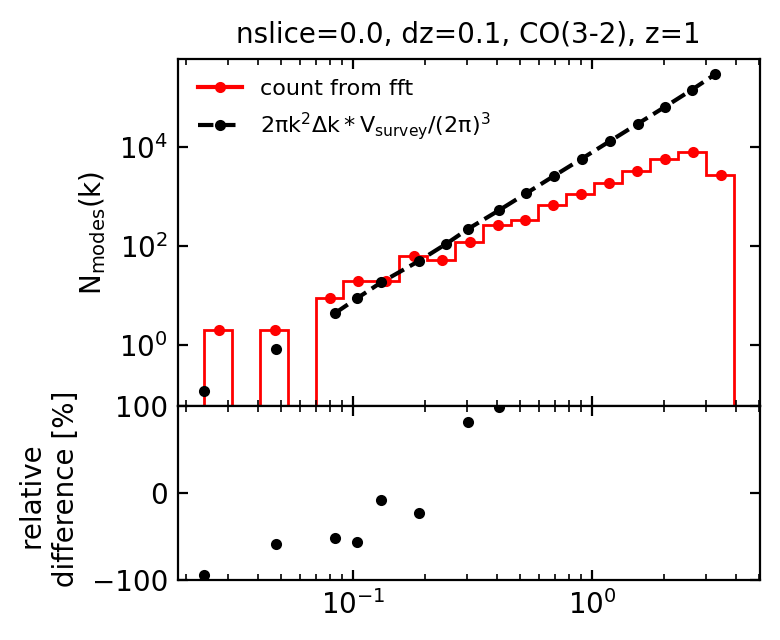

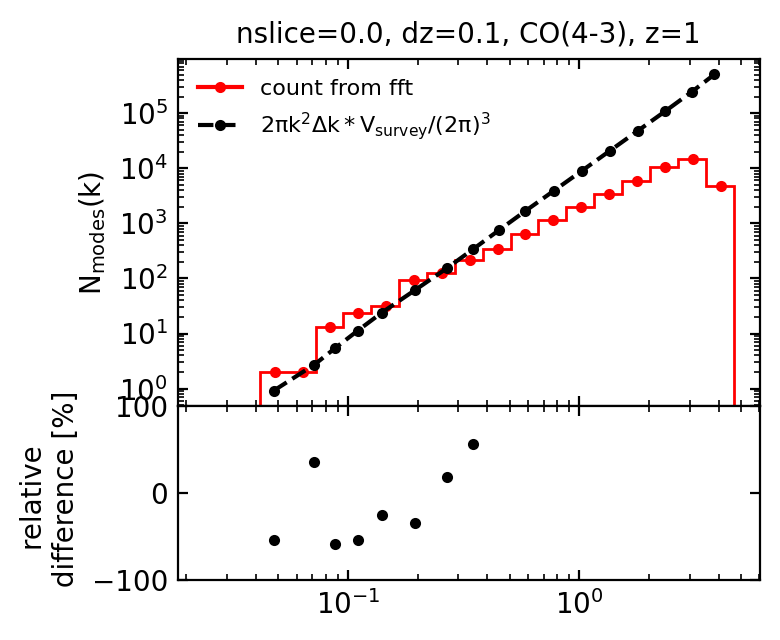

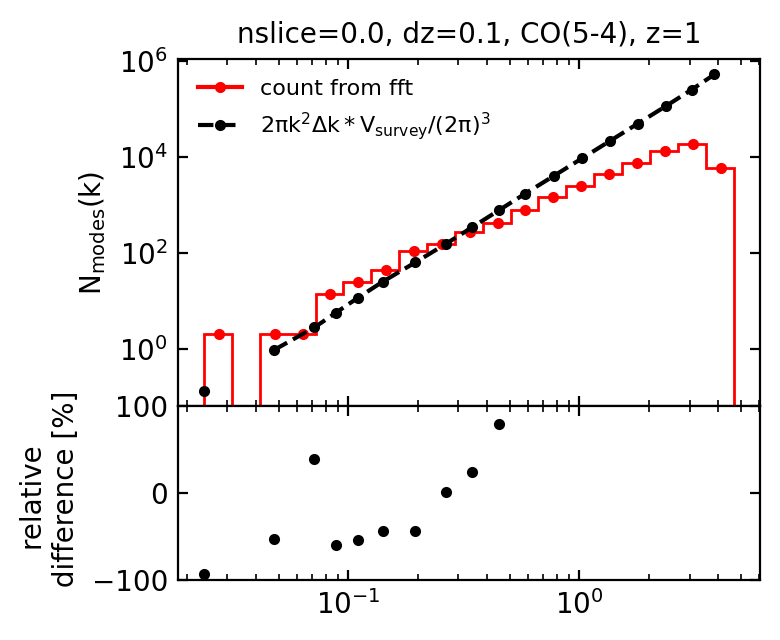

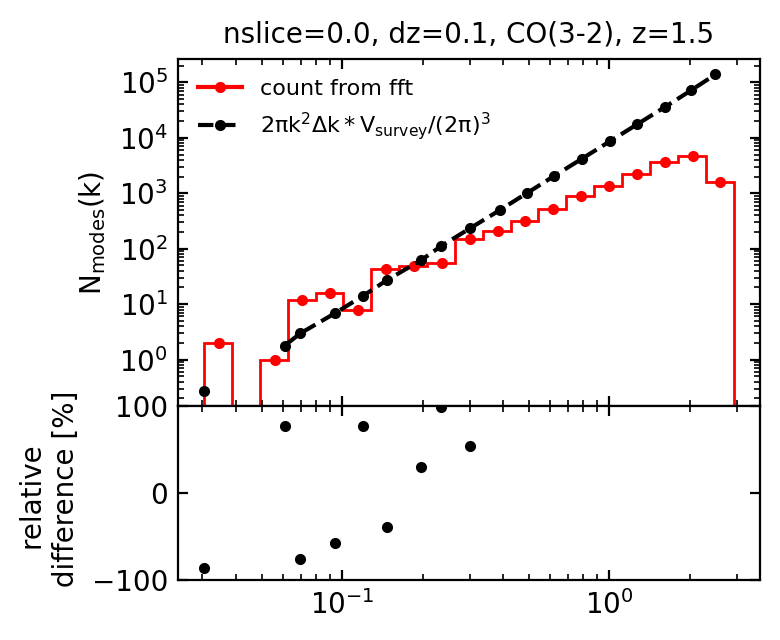

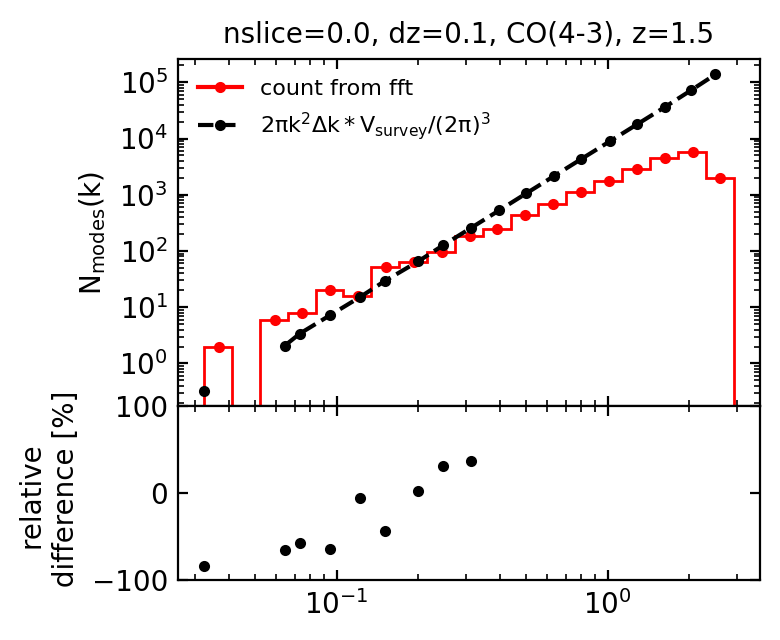

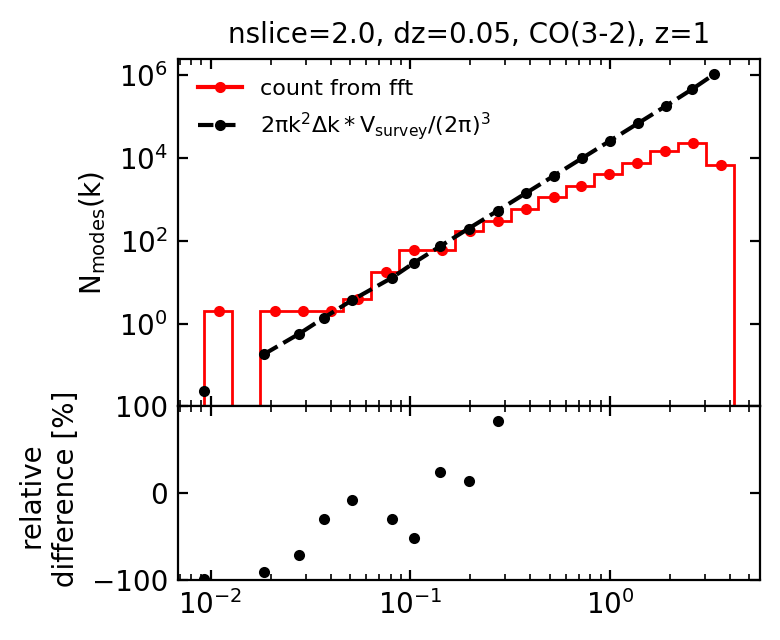

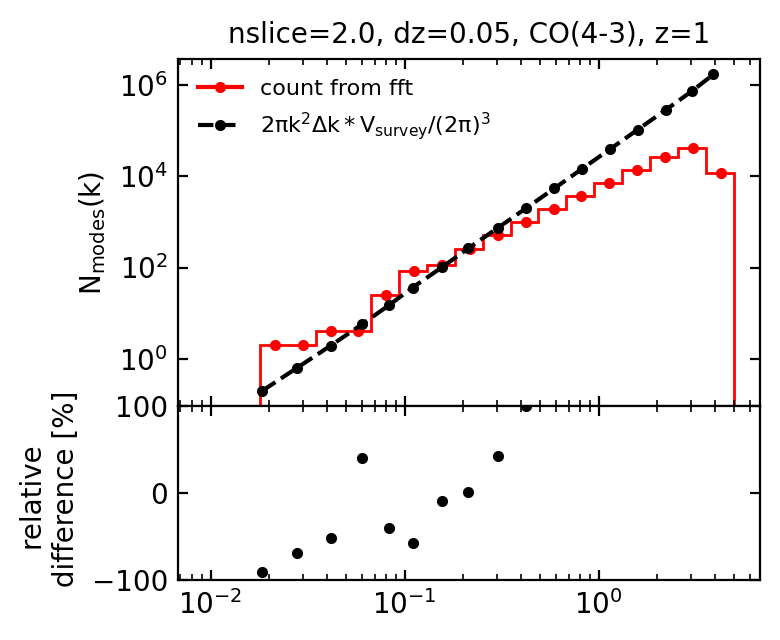

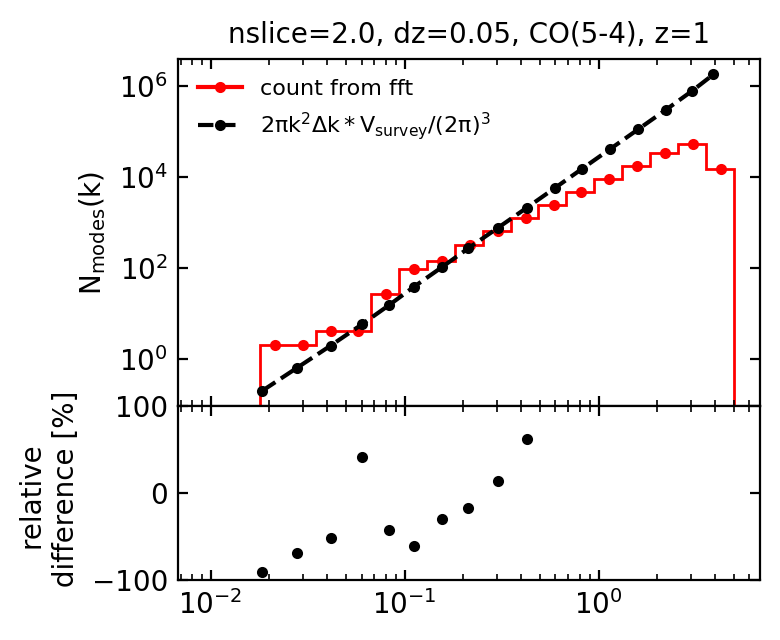

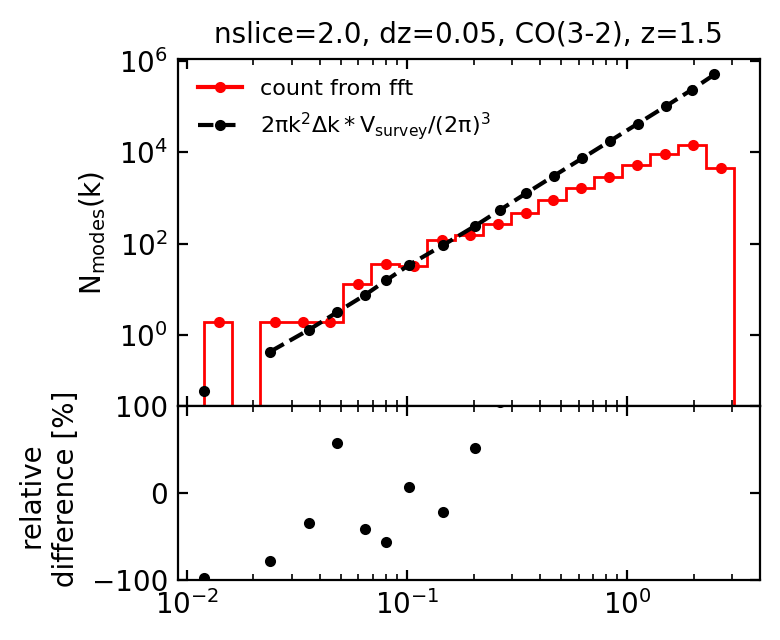

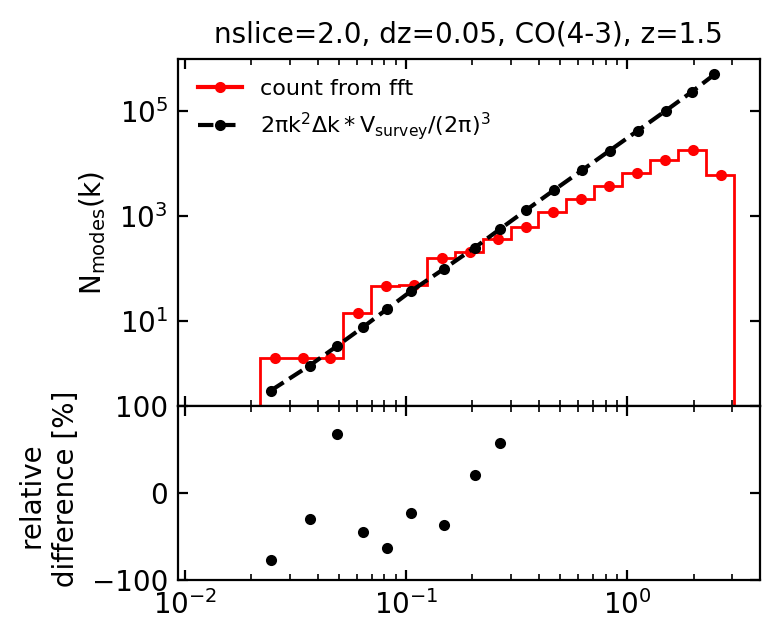

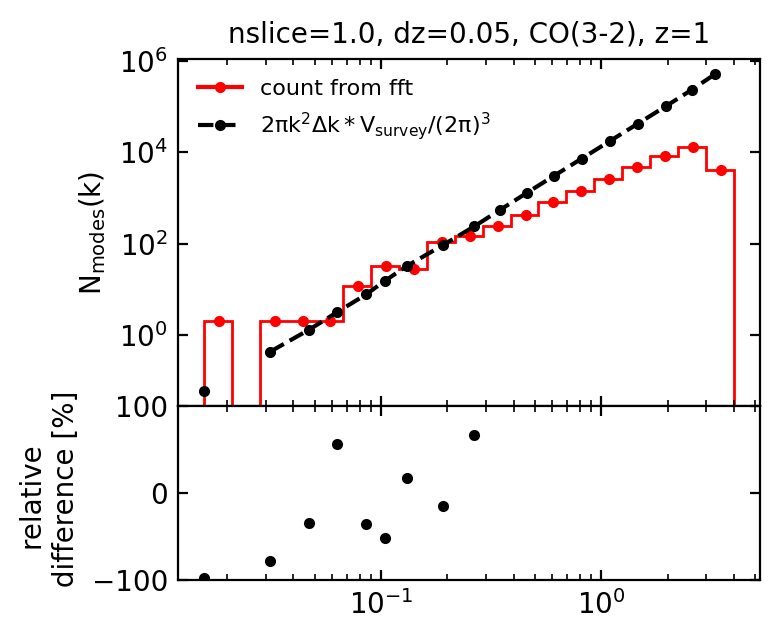

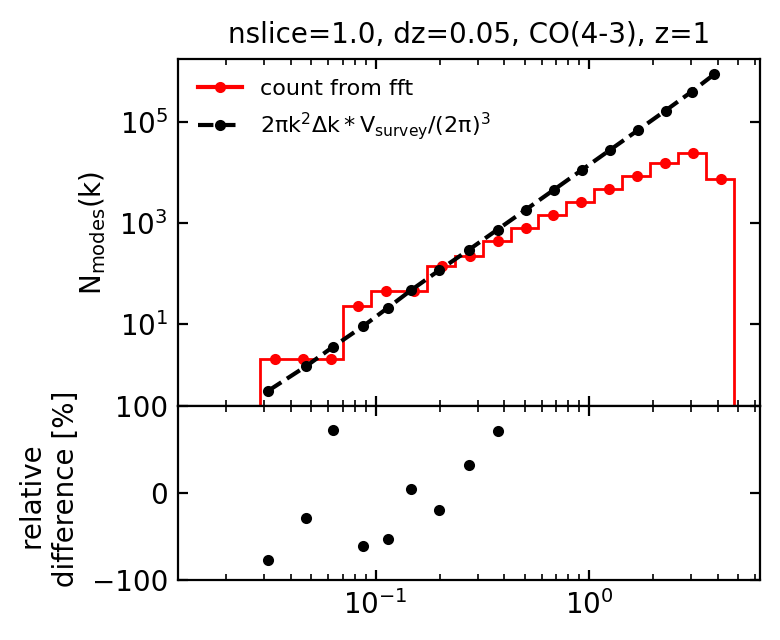

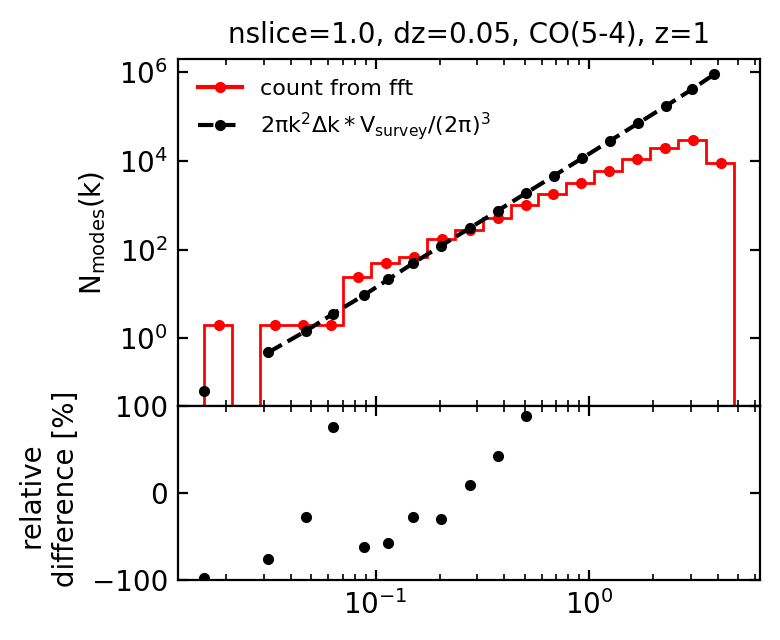

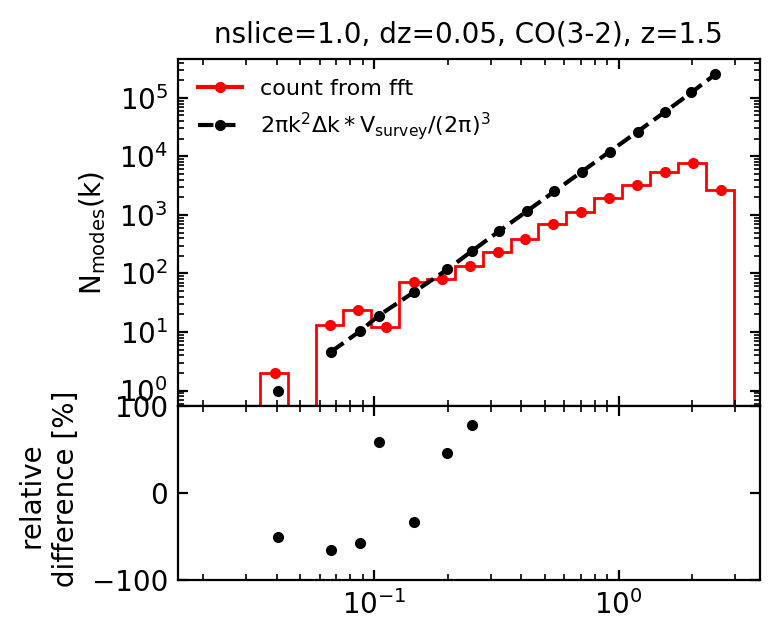

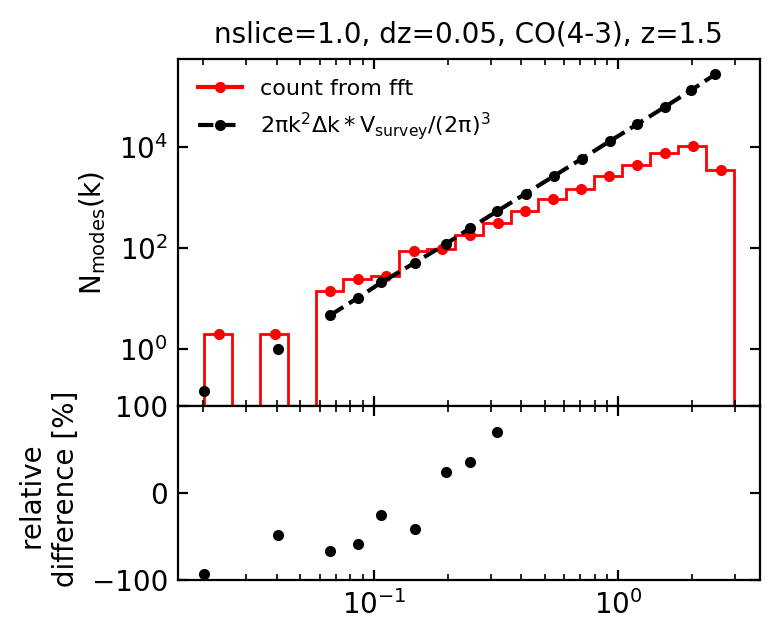

In [51]:
for i, (nslice, dz, line, rest_freq, z) in enumerate(params):

    nu_obs = rest_freq / (z+1) 
    if(nu_obs>=nu_range_HF[0]): FWHM=FWHM_HF
    else: FWHM = FWHM_LF

    zmin = z-(nslice*dz)-dz/2 
    zmax = z+(nslice*dz)+dz/2 
    nu_min = rest_freq / (1+zmax)
    nu_max = rest_freq / (1+zmin)

    res_angular = 2*FWHM
    ragrid= np.arange(0,np.sqrt(field_size).to(u.deg).value,(res_angular*u.arcsec).to(u.deg).value)
    decgrid= np.arange(0,np.sqrt(field_size).to(u.deg).value,(res_angular*u.arcsec).to(u.deg).value)

    ra_center = np.mean(ragrid)
    dec_center = np.mean(decgrid)
    delta_ra = np.max(ragrid) - np.min(ragrid)
    delta_dec = np.max(decgrid) - np.min(decgrid)
    nu_list = np.arange(nu_min, nu_max, dnu)
    zline = rest_freq/nu_list-1

    Dc_center = cosmo.comoving_distance(zline).value

    #all the coordinates will be in comoving units
    size_x = Dc_center * delta_ra * (np.pi/180) * np.cos(np.pi/180*dec_center)
    size_y = Dc_center * delta_dec * (np.pi/180) 

    #compute the coordinates in the cube
    ys = Dc_center * ( ragrid[:, np.newaxis]  - ra_center)  * (np.pi/180) * np.cos(np.pi/180*ragrid[:, np.newaxis])
    xs = Dc_center * ( decgrid[:, np.newaxis] - dec_center) * (np.pi/180)
        #box_size = np.min([size_x, size_y])
        #bins = np.linspace(-box_size/2, box_size/2, num = Nvox + 1)

    grid=np.array(np.meshgrid(ys,xs))
    cube = np.zeros((len(zline), len(ragrid), len(decgrid), 3))
    for i,zl in enumerate(zline):
        for j in range(len(ragrid)):
            for k in range(len(decgrid)):
                cube[i,j,k,0] = Dc_center[i]
                cube[i,j,k,1] = ys[j, i]
                cube[i,j,k,2] = xs[k, i]

    dc_center = cube[int(cube.shape[0]/2),int(cube.shape[1]/2),int(cube.shape[2]/2),0]
    centered_cube = cube.copy()
    centered_cube[:,:,:,0] -= dc_center

    BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
    fig, (ax, axr) = plt.subplots(2,1,figsize=(4, 3.3), dpi = 200, sharex=True, gridspec_kw={'height_ratios': [2,1]},)
    patchs = []
    
    ax.set_title(f'nslice={nslice}, dz={dz}, {line}, z={z}')
            
    kmaps_list = []
    kmaps_nyquist = []
    kperp_min_list = []
    kperp_max_list = []
            
    for zi in range(len(centered_cube[:,0,0,1])):
        res = centered_cube[zi, 1, 0,1]-centered_cube[zi, 0, 0, 1]
        #if(zii==0): res_perp_0 = res
        r_cylindrical = np.sqrt(centered_cube[zi,:,:,1]**2+centered_cube[zi,:,:,2]**2)
        kmap = 2*np.pi*give_map_spatial_freq(res, r_cylindrical.shape[1], r_cylindrical.shape[0])
        kmaps_list.append(kmap)

    Z = np.abs(centered_cube[:,0,0,0])
    lenght = Z[0]+Z[-1]
    res = Z[0]-Z[1]
    kz = 2*np.pi*give_map_spatial_freq_one_axis(res, len(zline))
    kz_arr = np.zeros(np.asarray(kmaps_list).shape)
    kz_arr[:,:,:] = kz[:,np.newaxis, np.newaxis]
    k = np.sqrt(np.asarray(kmaps_list)**2+kz[:,np.newaxis, np.newaxis]**2)/u.Mpc

    #Setting the binning of the k map
    k_binsnp = np.logspace(np.log10(k[k>0].min().value), np.log10(k.max().value), 20)
    nmodes, kbins = np.histogram(k, bins = k_binsnp/u.Mpc)
    kmean, kbins = np.histogram(k, bins = k_binsnp/u.Mpc, weights=k)
    kmean /= nmodes
    ax.stairs(nmodes,k_binsnp, color='r')
    points = np.diff(k_binsnp) 
    ax.plot(k_binsnp[:-1]+points/2, nmodes, 'or', markersize=3)
    #ax.plot(kmean, nmodes, 'xr')

    Vtot = 4/3*np.pi*(cosmo.comoving_distance(zline[0])**3-cosmo.comoving_distance(zline[-1])**3)
    Vsurvey =  (field_size).to(u.sr) * Vtot / (4*np.pi)
    Nmodes = 2 * np.pi * kmean**2 * np.diff(k_binsnp) * Vsurvey / (2*np.pi)**3
    ax.plot(kmean, Nmodes, '--ok',  markersize=3)
    #f = interp1d()
    axr.plot(kmean, ((Nmodes/nmodes).value-1)*100, 'ok', markersize=3)
    axr.set_ylim(-100,100)
    axr.set_ylabel('relative \n difference [%]')


    
    patch = mlines.Line2D([], [], color='r', linestyle="solid", marker='o',markersize=3, label='count from fft' ); patchs.append(patch);
    patch = mlines.Line2D([], [], color='k', linestyle="--",marker='o',markersize=3,label='$\\rm 2 \\pi k^2 \\Delta k *V_{survey} / (2\\pi)^3$' ); patchs.append(patch);

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('$\\rm N_{modes}(k)$')
    ax.legend(loc='upper left',handles = patchs, fontsize=8)
    ax.set_xlabel(r'$\rm ||k||$ [$\rm Mpc^{-1}$]')
    fig.tight_layout(); fig.subplots_adjust(hspace=.0)

    plt.rcParams.update({'xtick.direction':'in'})
    plt.rcParams.update({'ytick.direction':'in'})
    plt.rcParams.update({'xtick.top':True})
    plt.rcParams.update({'ytick.right':True})
    plt.rcParams.update({'legend.frameon':False})
    
        
